In [1]:
# Basic python packages
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from collections import defaultdict
import glob
import splitfolders
import cv2
import random

# General machine learning packages
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Packages related to images
from PIL import Image
import PIL

# Packages for neural networks
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, Embedding
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

In [2]:
# !pip install --upgrade tensorflow_hub

In [3]:
# Check if GPU works
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [145]:
def clean_data(path):
    df = pd.read_csv(path)
    df = df[df['Creator'] != ''] 
    df = df[df['Creator'] != 'anoniem']
    df = df[df['Creator'] != 'onbekend']
    df = df[df['Creator'].notna()]
    df = df.replace('Koning, Cornelis (?-1671)', 'Koning, Cornelis')
    return df

def preprocess_data(df, num_artworks = 10):
    df = df.groupby("Creator").filter(lambda x: len(x) >= num_artworks)
    le = preprocessing.LabelEncoder()
    le.fit(df.Creator)
    df['Creator_cat'] = le.transform(df.Creator)
    le.fit(df.Date)
    df['Date_cat'] = le.transform(df.Date)
    le.fit(df.Type)
    df['Type_cat'] = le.transform(df.Type)
    le.fit(df.Materials)
    df['Materials_cat'] = le.transform(df.Materials)
    return df

df = clean_data('../Data/Rijksmuseum/xml_files_full.csv')
rijksdata = preprocess_data(df, 1100)

In [146]:
rijksdata

,Identifier,Creator,Title,Date,Type,Materials,Creator_cat,Date_cat,Type_cat,Materials_cat
100,RP-T-1905-158(R),"Fokke, Simon","Jonge edelman, naar links in gebogen houding",1779,tekening,['papier'],0,158,9,21
101,RP-T-1905-158(V),"Fokke, Simon",Zittende man,1779,tekening,['papier'],0,158,9,21
2275,SK-C-5,Rembrandt Harmensz. van Rijn,Officieren en andere schutters van wijk II in ...,1642,schilderij,"['doek', 'olieverf']",5,22,7,1
2276,SK-C-6,Rembrandt Harmensz. van Rijn,De Staalmeesters: het college van staalmeester...,1662,schilderij,"['doek', 'olieverf']",5,42,7,1
2277,SK-A-3340,Rembrandt Harmensz. van Rijn,Borstbeeld van een man in oosterse kleding (),1635,schilderij,"['paneel', 'olieverf']",5,15,7,11
...,...,...,...,...,...,...,...,...,...,...
111753,RP-P-OB-102.936,"Picart, Bernard",Elegant gezelschap speelt het kaartspel Jeu de...,1709,prent,['papier'],4,88,6,21
111754,RP-P-OB-51.369X,"Picart, Bernard",Allegorische voorstelling met liefdesparen,1721,prent,['papier'],4,100,6,21
111788,RP-P-1896-A-19368-1738,"Luyken, Jan",Vroeg-christelijke gemeenschap luistert naar e...,1700,prent,['papier'],3,79,6,21
111816,RP-P-1896-A-19368-1436(V),"Luyken, Jan",Hollandse troepen bestormen de muur van Tienen...,1698,prent,['papier'],3,77,6,21


In [147]:
#Paths to different folders/files
image_dir = "../Data/Rijksmuseum/jpg2/"
split_image_dir = "../Data/Rijksmuseum/jpg2_split_1100/"
training_path = "../Data/Rijksmuseum/output_1100/train/"
validation_path = "../Data/Rijksmuseum/output_1100/val/"
testing_path = "../Data/Rijksmuseum/output_1100/test/"

img_size = (200, 200) #Size of the input of the neural networks
IMG_SHAPE = img_size + (3,)
batch_size = 256
n_labels_c1 = len(rijksdata.groupby('Creator').count())
n_labels_c2 = len(rijksdata.groupby('Type').count())
n_labels_c3 = len(rijksdata.groupby('Date').count())
n_labels_c4 = len(rijksdata.groupby('Materials').count())

In [148]:
labels = rijksdata[['Identifier', 'Creator_cat', 'Type_cat', 'Date_cat', 'Materials_cat']]
# sorted_list = sorted(list(labels.Type_cat.unique()))
# sorted_list
# labels[labels['Identifier'] == 'RP-P-1878-A-550']

In [149]:
labels

,Identifier,Creator_cat,Type_cat,Date_cat,Materials_cat
100,RP-T-1905-158(R),0,9,158,21
101,RP-T-1905-158(V),0,9,158,21
2275,SK-C-5,5,7,22,1
2276,SK-C-6,5,7,42,1
2277,SK-A-3340,5,7,15,11
...,...,...,...,...,...
111753,RP-P-OB-102.936,4,6,88,21
111754,RP-P-OB-51.369X,4,6,100,21
111788,RP-P-1896-A-19368-1738,3,6,79,21
111816,RP-P-1896-A-19368-1436(V),3,6,77,21


In [150]:
print(n_labels_c1, n_labels_c2, n_labels_c3, n_labels_c4)

6 12 190 27


In [151]:
train_dict = {}
val_dict = {}
test_dict = {}

for fol in os.listdir(training_path):
    for file in os.listdir(os.path.join(training_path, fol)):
        im_path = os.path.join(os.path.join(training_path, fol), file)
        train_dict[im_path] = (labels[labels['Identifier'] == file[:-4]]['Creator_cat'].values[0], 
                               labels[labels['Identifier'] == file[:-4]]['Type_cat'].values[0], 
                               labels[labels['Identifier'] == file[:-4]]['Date_cat'].values[0], 
                               labels[labels['Identifier'] == file[:-4]]['Materials_cat'].values[0])
        
for fol in os.listdir(validation_path):
    for file in os.listdir(os.path.join(validation_path, fol)):
        im_path = os.path.join(os.path.join(validation_path, fol), file)
        val_dict[im_path] = (labels[labels['Identifier'] == file[:-4]]['Creator_cat'].values[0], 
                             labels[labels['Identifier'] == file[:-4]]['Type_cat'].values[0], 
                             labels[labels['Identifier'] == file[:-4]]['Date_cat'].values[0], 
                             labels[labels['Identifier'] == file[:-4]]['Materials_cat'].values[0])
        
for fol in os.listdir(testing_path):
    for file in os.listdir(os.path.join(testing_path, fol)):
        im_path = os.path.join(os.path.join(testing_path, fol), file)
        test_dict[im_path] = (labels[labels['Identifier'] == file[:-4]]['Creator_cat'].values[0], 
                              labels[labels['Identifier'] == file[:-4]]['Type_cat'].values[0], 
                              labels[labels['Identifier'] == file[:-4]]['Date_cat'].values[0], 
                              labels[labels['Identifier'] == file[:-4]]['Materials_cat'].values[0])

In [11]:
def create_model_inception(c_1, c_2):
    inputs = tf.keras.layers.Input(shape=[img_size[0], img_size[1], 3], name='main_input')
    main_branch = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/inception_v3/classification/4")(inputs)
    main_branch = tf.keras.layers.Flatten()(main_branch)
    main_branch = tf.keras.layers.Dense(1024, activation='relu')(main_branch)
    main_branch = tf.keras.layers.Dropout(0.5)(main_branch)

    class1_pred = Dense(c_1, activation='softmax', name='c1_output')(main_branch)
    class2_pred = Dense(c_2, activation='softmax', name='c2_output')(main_branch)

    model = Model(inputs = inputs, outputs = [class1_pred, class2_pred])
    
    for layer in model.layers[:126]:
        layer.trainable = False
    for layer in model.layers[126:]:
        layer.trainable = True
    
    return model

In [97]:
def create_model_xception(c_1, c_2, c_3, c_4):
    base_model = tf.keras.applications.Xception(input_shape = IMG_SHAPE, 
                                                   weights = 'imagenet', 
                                                   include_top=False)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)

    x_c1 = Dense(512, activation='relu', name='dense_5_c1')(x)
    x_c1 = Dropout(0.5, name='dropout_5_c1')(x_c1)
    x_c2 = Dense(512, activation='relu', name='dense_5_c2')(x)
    x_c2 = Dropout(0.5, name='dropout_5_c2')(x_c2)
    x_c3 = Dense(512, activation='relu', name='dense_5_c3')(x)
    x_c3 = Dropout(0.5, name='dropout_5_c3')(x_c3)
    x_c4 = Dense(512, activation='relu', name='dense_5_c4')(x)
    x_c4 = Dropout(0.5, name='dropout_5_c4')(x_c4)

    class1_pred = Dense(c_1, activation='softmax', name='c1_output')(x_c1)
    class2_pred = Dense(c_2, activation='softmax', name='c2_output')(x_c2)
    class3_pred = Dense(c_3, activation='softmax', name='c3_output')(x_c3)
    class4_pred = Dense(c_4, activation='softmax', name='c4_output')(x_c4)

    model = Model(inputs = base_model.input, outputs = [class1_pred, class2_pred, class3_pred, class4_pred])
    
    for layer in model.layers[:126]:
        layer.trainable = False
    for layer in model.layers[126:]:
        layer.trainable = True
    
    return model

In [98]:
def train_gen(training_dict, batch_size=10):
    """
    Source: https://github.com/daveboat/multitask-image-classification-keras-example
    Our image generator. This should load a batch of images of size batch_size using our training dict, resize them
    all to 200x200, and then stack them together into a (batch_size, 200, 200, 3) tensor, or a stack of (200, 200, 3)
    images
    Target is a stack of [targets_c1, targets_c2]
    Should return [image batch, target]
    """
    training_list = list(training_dict.items())
    training_len = len(training_list)
#     print('training_len = %d' % training_len)
    random.shuffle(training_list)
    list_index = 0
    current_batch_size = 0

    # yield loop
    while 1:
        images = []
        targets_c1 = []
        targets_c2 = []
        targets_c3 = []
        targets_c4 = []
        while current_batch_size < batch_size:
            images.append( image.img_to_array( image.load_img( training_list[list_index][0], target_size=img_size ) ) / 255.0 )
            targets_c1.append(training_list[list_index][1][0])
            targets_c2.append(training_list[list_index][1][1])
            targets_c3.append(training_list[list_index][1][2])
            targets_c4.append(training_list[list_index][1][3])
            list_index+=1
            current_batch_size += 1
            #print("list_index = %d, current_batch_size = %d" %(list_index, current_batch_size))
            if list_index >= training_len: list_index = 0
        current_batch_size = 0
        targets = [np.array(targets_c1), np.array(targets_c2), np.array(targets_c3), np.array(targets_c4)]

        yield [np.stack(images, axis=0)], targets

In [153]:
batch_size = 128
epochs = 20

# initialize training and validation generators
gen = train_gen(train_dict, batch_size)
val_gen = train_gen(val_dict, batch_size)

steps = len(train_dict) // batch_size
val_steps = len(val_dict) // batch_size

Try with toy dataset and try to locate issue

vanishing gradient, adjust clipping

In [136]:
# # initialize and compile model
# model = create_model_inception(n_labels_c1, n_labels_c2)

# model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), #, clipvalue=0.5
#               loss={'c1_output': 'sparse_categorical_crossentropy', 'c2_output': 'sparse_categorical_crossentropy'},
#               loss_weights={'c1_output': 0.5, 'c2_output': 0.5},
#               metrics={'c1_output': 'accuracy', 'c2_output': 'accuracy'})

# # fit model
# model.fit(gen, steps_per_epoch=steps, epochs=epochs, validation_data=val_gen, validation_steps=val_steps)

In [155]:
# initialize and compile model
model2 = create_model_xception(n_labels_c1, n_labels_c2, n_labels_c3, n_labels_c4)

model2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001, clipvalue=0.5),
              loss={'c1_output': 'sparse_categorical_crossentropy', 'c2_output': 'sparse_categorical_crossentropy', 'c3_output': 'sparse_categorical_crossentropy', 'c4_output': 'sparse_categorical_crossentropy'},
              loss_weights={'c1_output': 0.5, 'c2_output': 0.5, 'c3_output': 0.5, 'c4_output': 0.5},
              metrics={'c1_output': 'accuracy', 'c2_output': 'accuracy', 'c3_output': 'accuracy', 'c4_output': 'accuracy'})

# fit model
hist = model2.fit(gen, steps_per_epoch=steps, epochs=epochs, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
45/45 [==============================] - 18s 345ms/step - loss: 4.7163 - c1_output_loss: 1.3933 - c2_output_loss: 1.1302 - c3_output_loss: 5.3283 - c4_output_loss: 1.5809 - c1_output_accuracy: 0.5280 - c2_output_accuracy: 0.6653 - c3_output_accuracy: 0.0818 - c4_output_accuracy: 0.6108 - val_loss: 4.1425 - val_c1_output_loss: 1.2226 - val_c2_output_loss: 0.8688 - val_c3_output_loss: 4.8348 - val_c4_output_loss: 1.3589 - val_c1_output_accuracy: 0.6393 - val_c2_output_accuracy: 0.9557 - val_c3_output_accuracy: 0.1602 - val_c4_output_accuracy: 0.9609
Epoch 2/20
45/45 [==============================] - 15s 341ms/step - loss: 2.7481 - c1_output_loss: 0.8081 - c2_output_loss: 0.2182 - c3_output_loss: 4.1906 - c4_output_loss: 0.2793 - c1_output_accuracy: 0.7226 - c2_output_accuracy: 0.9441 - c3_output_accuracy: 0.1929 - c4_output_accuracy: 0.9571 - val_loss: 3.3214 - val_c1_output_loss: 0.9904 - val_c2_output_loss: 0.4283 - val_c3_output_loss: 4.5079 - val_c4_output_loss: 0.7162 - 

45/45 [==============================] - 15s 342ms/step - loss: 0.2793 - c1_output_loss: 0.0266 - c2_output_loss: 0.0027 - c3_output_loss: 0.5222 - c4_output_loss: 0.0070 - c1_output_accuracy: 0.9946 - c2_output_accuracy: 0.9997 - c3_output_accuracy: 0.9036 - c4_output_accuracy: 0.9986 - val_loss: 1.7048 - val_c1_output_loss: 0.4781 - val_c2_output_loss: 0.1158 - val_c3_output_loss: 2.6155 - val_c4_output_loss: 0.2002 - val_c1_output_accuracy: 0.8594 - val_c2_output_accuracy: 0.9753 - val_c3_output_accuracy: 0.4375 - val_c4_output_accuracy: 0.9661
Epoch 16/20
45/45 [==============================] - 15s 341ms/step - loss: 0.2284 - c1_output_loss: 0.0200 - c2_output_loss: 0.0024 - c3_output_loss: 0.4267 - c4_output_loss: 0.0076 - c1_output_accuracy: 0.9967 - c2_output_accuracy: 0.9997 - c3_output_accuracy: 0.9288 - c4_output_accuracy: 0.9981 - val_loss: 1.7282 - val_c1_output_loss: 0.4925 - val_c2_output_loss: 0.1264 - val_c3_output_loss: 2.6326 - val_c4_output_loss: 0.2048 - val_c1_out

In [156]:
def plot_history(history):
    #Plots the training data.
    plt.plot(history.history['c1_output_accuracy'], label='c1 accuracy')
    plt.plot(history.history['val_c1_output_accuracy'], label = 'c1 val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show() 

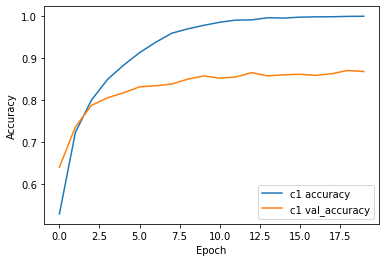

In [157]:
plot_history(hist)

In [138]:
# Save model
# model2.save("models/_Xception_multitask_100")

# Load model
# model = tf.keras.models.load_model('./models/_ResNet152V2model')
# model.load_weights('../Model_weights/ResNet152V2model/')


INFO:tensorflow:Assets written to: models/_Xception_multitask_100\assets


# Predict the test set
We also have to predict the real test set

In [103]:
# test_dict

In [139]:
df = []

for path, labels in test_dict.items():
    img = image.img_to_array( image.load_img( path, target_size=img_size ) ) / 255.0
    pred_c1, pred_c2, pred_c3, pred_c4 = model2.predict(np.array([img]))
    df.append([path, labels[0], labels[1], labels[2], labels[3], pred_c1.argmax(axis=-1)[0], pred_c2.argmax(axis=-1)[0], pred_c3.argmax(axis=-1)[0], pred_c4.argmax(axis=-1)[0]])

In [105]:
# df

In [140]:
df2 = pd.DataFrame(df)
df2.columns = ['path', 'cat1_true', 'cat2_true', 'cat3_true', 'cat4_true', 'cat1_pred', 'cat2_pred', 'cat3_pred', 'cat4_pred']
df2

,path,cat1_true,cat2_true,cat3_true,cat4_true,cat1_pred,cat2_pred,cat3_pred,cat4_pred
0,../Data/Rijksmuseum/output_100/test/Aldegrever...,0,77,115,155,0,0,0,0
1,../Data/Rijksmuseum/output_100/test/Aldegrever...,0,77,115,155,0,0,0,0
2,../Data/Rijksmuseum/output_100/test/Aldegrever...,0,77,115,155,0,0,0,0
3,../Data/Rijksmuseum/output_100/test/Aldegrever...,0,77,117,155,0,0,0,0
4,../Data/Rijksmuseum/output_100/test/Aldegrever...,0,77,117,155,0,0,0,0
...,...,...,...,...,...,...,...,...,...
10618,../Data/Rijksmuseum/output_100/test/Woodbury &...,182,33,428,15,0,0,0,0
10619,../Data/Rijksmuseum/output_100/test/Woodbury &...,182,33,428,15,0,0,0,0
10620,../Data/Rijksmuseum/output_100/test/Woodbury &...,182,4,428,14,0,0,0,0
10621,../Data/Rijksmuseum/output_100/test/Woodbury &...,182,33,428,15,0,0,0,0


In [ ]:
# df2['cat1_pred'].unique()

In [ ]:
# def predict_test(model, labels):
#     preds = model.predict(test_generator)
#     preds_cls_idx = preds.argmax(axis=-1)
#     idx_to_cls = {v: k for k, v in train_generator.class_indices.items()}
#     preds_cls = np.vectorize(idx_to_cls.get)(preds_cls_idx)
#     filenames_to_cls = list(zip(test_generator.filenames, preds_cls))
    
#     l = []
#     n = []
#     t = []
#     for p in filenames_to_cls:
#         n.append(p[0].split("\\")[-1][:-4])
#         l.append(p[1])
#         t.append(labels[labels['Identifier'] == p[0].split("\\")[-1][:-4]]['Creator'].values[0])
#     return pd.DataFrame(list(zip(n, l, t)), columns=['img_name', 'predicted label', 'true label'])

# res = predict_test(model2, labels)

In [ ]:
# res

In [141]:
from sklearn.metrics import accuracy_score
accuracy_c1 = accuracy_score(df2['cat1_true'], df2['cat1_pred'])
accuracy_c1

0.007154287865951238

In [142]:
accuracy_c2 = accuracy_score(df2['cat2_true'], df2['cat2_pred'])
accuracy_c2

9.413536665725314e-05

In [143]:
accuracy_c3 = accuracy_score(df2['cat3_true'], df2['cat3_pred'])
accuracy_c3

0.0

In [144]:
accuracy_c4 = accuracy_score(df2['cat4_true'], df2['cat4_pred'])
accuracy_c4

9.413536665725314e-05